In [1]:
# Imports
import numpy as np
import pandas as pd

# import utilities
import os
import time

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 使用 DenseNet 和 PyTorch 对 CIFAR-10 图像进行分类

## 简介
CIFAR-10 数据集包含了60000张 32x32 的彩色图像，分为10个类别，每个类别有6000张图片。数据集包括50000张训练图像和10000张测试图像。

该数据集被分为五个训练批次和一个测试批次，每个批次包含10000张图像。测试批次包含每个类别中随机选择的1000张图像。训练批次包含其余图像，但某些训练批次可能包含某一类别的图像比其他类别更多。在这些训练批次中，每个类别恰好包含5000张图像。

我将尝试使用 DenseNet 神经网络架构在 PyTorch 中对这个数据集中的图像进行分类。我使用了来自这个 GitHub 仓库中的 DenseNet 实现代码

我将直接从 Torchvision 下载 CIFAR-10 数据集。

## 加载数据

为了加载数据集，我使用 Torchvision 中的 CIFAR-10 数据集和 PyTorch 的数据加载器（dataloaders）。并使用 PyTorch 的 transforms 定义训练和测试转换。

In [2]:
#为训练数据定义转换函数
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

#为训练数据定义转换函数
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

#为训练数据定义数据加载器函数
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):
    
    transform_train = train_transform
    cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_training_loader

# define test dataloader
def get_testing_dataloader(test_transform, batch_size=128, num_workers=0, shuffle=True):

    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader

In [3]:
#获取训练和测试数据集的数据加载器
trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)

Files already downloaded and verified
Files already downloaded and verified


查看一些来自训练数据集的随机图像

In [4]:
#指定类别的名称
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

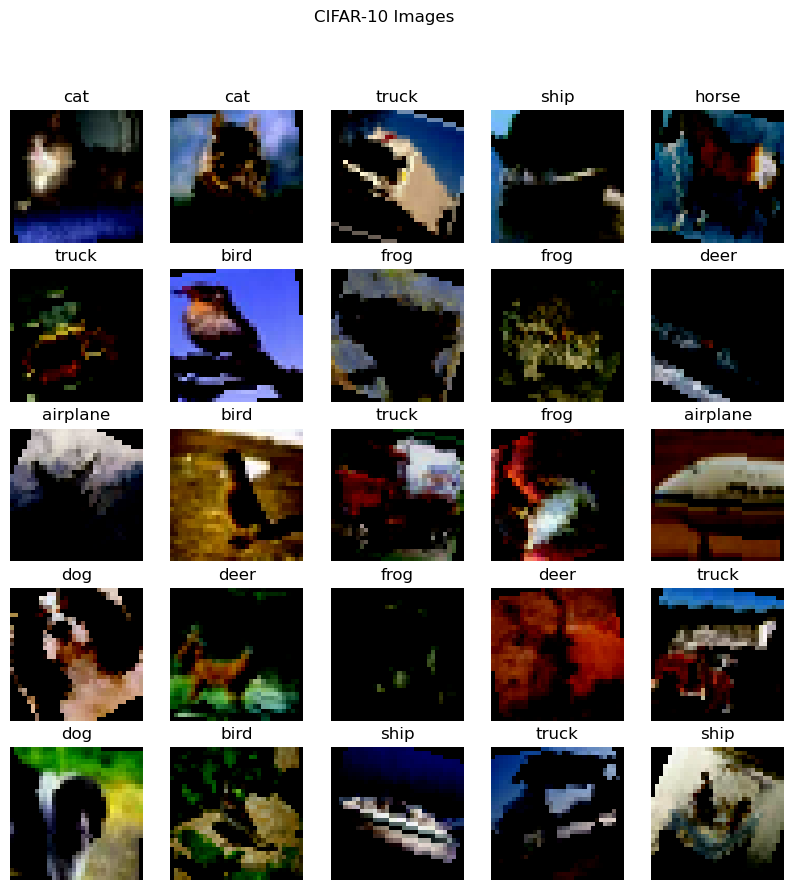

In [5]:
# 从训练数据集中绘制25张随机图像
fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
for batch_idx, (inputs, labels) in enumerate(trainloader):
    for im in range(25):
        image = inputs[im].permute(1, 2, 0)
        i = im // 5
        j = im % 5
        axs[i,j].imshow(image.numpy())
        axs[i,j].axis('off')
        axs[i,j].set_title(classes_dict[int(labels[im].numpy())])
        
    break;

# 设置总标题
plt.suptitle('CIFAR-10 Images')
plt.show()

## 构建模型

我将使用在这个仓库中实现的DenseNet模型：

In [6]:
# 瓶颈层。尽管每层只产生k个输出特征图，但它通常有更多输入。在每个3×3卷积之前可以引入一个1×1卷积作为瓶颈层，以减少输入特征图的数量，从而提高计算效率。
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #让每个1×1卷积产生4k个特征图
        inner_channel = 4 * growth_rate

        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #实验中使用的过渡层由一个批量归一化层组成，接着是一个1×1的卷积层，然后是一个2×2的平均池化层
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B 代表瓶颈层。
#C 代表压缩因子（0≤θ≤1）
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        #在进入第一个密集块之前，对输入图像执行具有16个（或对于DenseNet-BC是增长率两倍的）输出通道的卷积。
        inner_channels = 2 * growth_rate

        #对于具有3×3卷积核的卷积层，输入的每一边都通过填充一个像素点来实现零填充，以保持特征图的大小不变。
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #如果一个密集块包含m个特征图，我们让随后的过渡层生成θm个输出特征图，其中0 < θ ≤ 1被称为压缩因子。
            out_channels = int(reduction * inner_channels) 
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

## 训练模型
设置训练参数:

In [7]:
# 轮次数
epochs = 50
# 学习率
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

初始化模型：

In [8]:
model = densenet121()

初始化损失函数和优化器：

In [9]:
# 设置损失函数
criterion = nn.CrossEntropyLoss()

# 设置优化器，仅训练分类器参数，冻结特征参数
optimizer = Adam(model.parameters(), lr=learning_rate)

In [10]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

您可以运行以下代码来训练模型：

In [11]:
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 计算训练集的top-1准确率。
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # 计算训练集的top-3准确率。
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # 计算测试集的top-1准确率。
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # 计算测试集的top-3准确率。
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    #train_stats = pd.concat({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)
    current_epoch_stats = pd.DataFrame([{'Epoch': epoch,'Time per epoch': time_elapsed,'Avg time per step': time_elapsed/len(trainloader),'Train loss': running_loss/len(trainloader),'Train accuracy': train_accuracy/len(trainloader),'Train top-3 accuracy': top3_train_accuracy/len(trainloader),'Test loss': test_loss/len(testloader),'Test accuracy': test_accuracy/len(testloader),'Test top-3 accuracy': top3_test_accuracy/len(testloader)}])
    train_stats = pd.concat([train_stats, current_epoch_stats], ignore_index=True)
    
    running_loss = 0
    model.train()

Epoch 1/50.. Time per epoch: 94.4985.. Average time per step: 0.2417.. Train loss: 1.4778.. Train accuracy: 0.4575.. Top-3 train accuracy: 0.7879.. Test loss: 1.1094.. Test accuracy: 0.5993.. Top-3 test accuracy: 0.8778


C:\Users\FanYulong\AppData\Local\Temp\ipykernel_10144\1672340987.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_stats = pd.concat([train_stats, current_epoch_stats], ignore_index=True)


Epoch 2/50.. Time per epoch: 93.1724.. Average time per step: 0.2383.. Train loss: 1.0860.. Train accuracy: 0.6072.. Top-3 train accuracy: 0.8836.. Test loss: 1.0748.. Test accuracy: 0.6239.. Top-3 test accuracy: 0.8973
Epoch 3/50.. Time per epoch: 93.5704.. Average time per step: 0.2393.. Train loss: 0.9248.. Train accuracy: 0.6675.. Top-3 train accuracy: 0.9113.. Test loss: 0.7987.. Test accuracy: 0.7116.. Top-3 test accuracy: 0.9338
Epoch 4/50.. Time per epoch: 92.9406.. Average time per step: 0.2377.. Train loss: 0.7929.. Train accuracy: 0.7185.. Top-3 train accuracy: 0.9324.. Test loss: 0.6913.. Test accuracy: 0.7623.. Top-3 test accuracy: 0.9420
Epoch 5/50.. Time per epoch: 93.4129.. Average time per step: 0.2389.. Train loss: 0.7012.. Train accuracy: 0.7530.. Top-3 train accuracy: 0.9435.. Test loss: 0.6391.. Test accuracy: 0.7763.. Top-3 test accuracy: 0.9547
Epoch 6/50.. Time per epoch: 93.1445.. Average time per step: 0.2382.. Train loss: 0.6283.. Train accuracy: 0.7812.. Top

 将训练日志保存到一个 csv 文件中：

In [12]:
train_stats.to_csv('train_log_DenseNet121.csv')

## 分析训练日志
绘制测试和训练准确率以及测试和训练损失图表

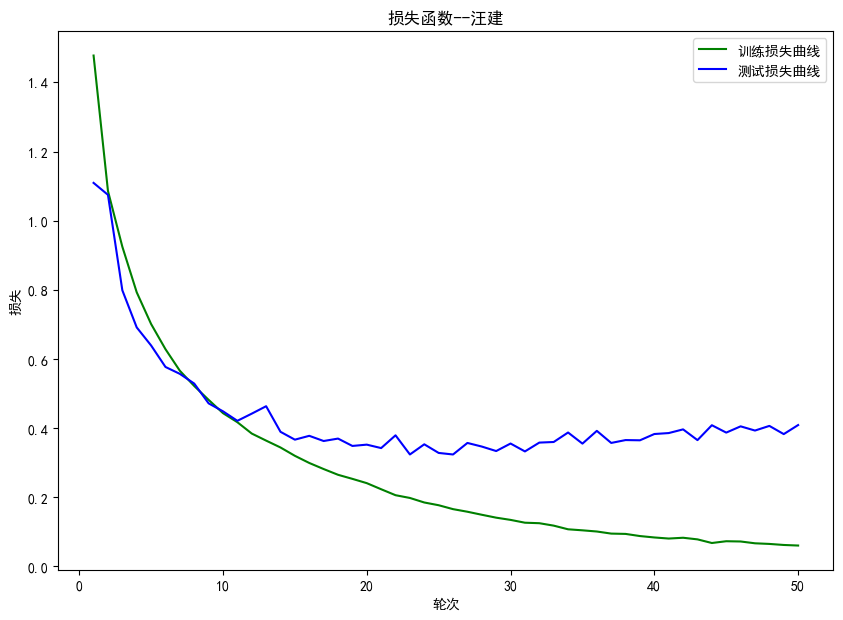

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("损失函数--汪建")
plt.xlabel("轮次")
plt.ylabel("损失");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='训练损失曲线');
ax.plot(x, train_stats['Test loss'].values, '-b', label='测试损失曲线');

plt.legend()

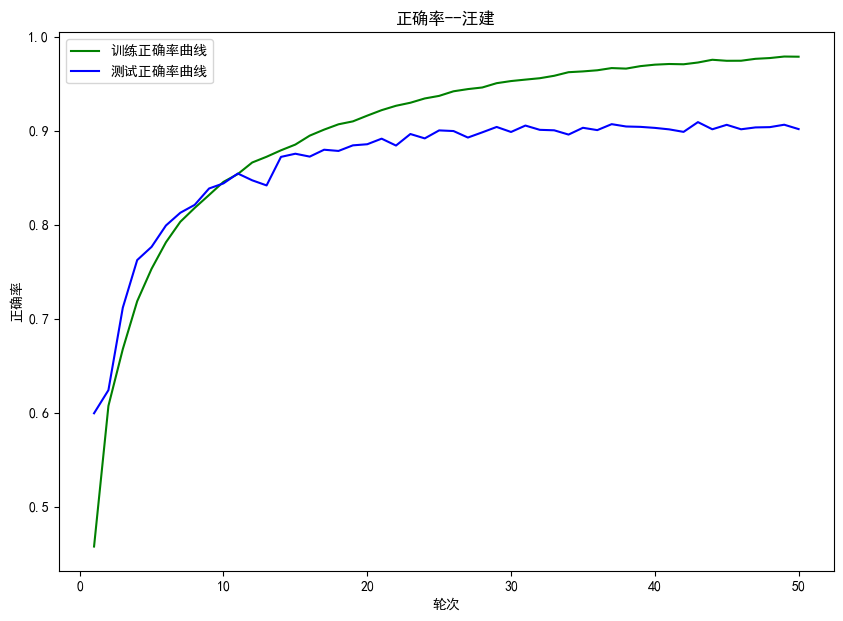

In [14]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("正确率--汪建")
plt.xlabel("轮次")
plt.ylabel("正确率");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='训练正确率曲线');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='测试正确率曲线');

plt.legend()

## 使用模型对图像进行分类
使用模型对训练集中的图像进行分类，并可视化预测结果：

In [15]:
def view_classify(img, ps, title):
    
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(classes_dict.values()), size='small');
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


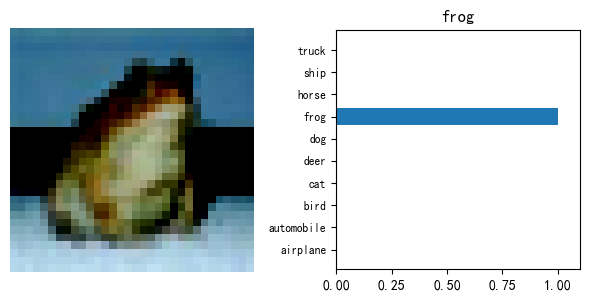

In [16]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;

## 结论
使用 DenseNet 模型，我在测试数据集上实现了约90%的准确率。